# Using Gemini and GigaChat and creation of prose dataset

In this notebook you can see the code for evaluation Gigachat and Gemini and creation of prose-to-poetry dataset 

## General functions and imports

In [ ]:
from time import sleep
import pandas as pd

system_instruction = '''Вы – талантливый поэт, создающий русскую поэзию. При преобразовании прозы в стихотворение соблюдайте следующие правила:\n''' \
                    '''1. Рифмовка: используйте заданную схему рифм.\n''' \
                    '''2. Размер: пишите в указанном метре и соблюдайте структуру чередования ударных и безударных слогов.\n''' \
                    '''3. Объём: стихотворение должно содержать ровно 4 строки.\n''' \
                    '''4. Содержание: сохраняйте ключевые образы, эмоции, детали описаний и действия из исходного текста.\n''' \
                    '''5. Выразительность: сделайте текст поэтичным и насыщенным.\n''' \
                    '''6. Формат: в ответе должно быть исключительно само стихотворение без комментариев.\n'''

system_instruction_generate = '''Вы – талантливый поэт, создающий русскую поэзию. При написании стихотворения соблюдайте следующие правила:\n''' \
                    '''1. Рифмовка: используйте заданную схему рифм.\n''' \
                    '''2. Размер: пишите в указанном метре и соблюдайте структуру чередования ударных и безударных слогов.\n''' \
                    '''3. Объём: стихотворение должно содержать ровно 4 строки.\n''' \
                    '''5. Выразительность: сделайте текст поэтичным и насыщенным.\n''' \
                    '''6. Формат: в ответе должно быть исключительно само стихотворение без комментариев.\n'''

system_instruction_inv = '''Вы – профессиональный литературный редактор, специалист по адаптации русской поэзии в художественную прозу. Преобразуйте данное стихотворение в прозаический текст, соблюдая следующие правила:\n''' \
        '''1. Сохранение смысла: передайте основное содержание, образы, идеи и настроение стихотворения.\n''' \
        '''2. Объём: длина полученного текста должна соответствовать объёму исходного стихотворения.\n''' \
        '''3. Грамотная стилистика: используйте литературный язык, избегая слишком сухого или официального тона.\n''' \
        '''4. Связность и плавность: стройте текст логично и последовательно, обеспечивая естественный поток мысли.\n''' \
        '''5. Передача эмоций: сохраняйте эмоциональную окраску, экспрессию и художественные детали оригинала.\n''' \
        '''6. Избегание ритма и рифмы: уберите поэтические конструкции, но при необходимости используйте выразительные средства прозы (метафоры, эпитеты и т. д.).\n''' \
        '''7. Формат: в ответе должно быть исключительно результат без комментариев.\n'''

meters = {
    'ямб': 'ямбический - чередуются ударные и безударные слоги, первый слог строки безударный',
    'iambos': 'ямбический - чередуются ударные и безударные слоги, первый слог строки безударный',
    'choreios': 'хорей - чередуются ударные и безударные слоги, первый слог строки ударный',
    'dolnik3': 'дольник - стихотворный размер с переменным количеством безударных слогов между ударными',
    'amphibrachys': 'амфибрахий - трехсложный размер, где ударение падает на второй слог',
    'anapaistos': 'анапест - трехсложный размер, где ударение падает на третий слог',
    'daktylos': 'дактиль - трехсложный размер, где ударение падает на первый слог',
    'dolnik2': 'дольник - стихотворный размер с переменным количеством безударных слогов между ударными',
}

def get_prompt(text, scheme='ABAB', meter='ямб'):
    if text is None:
        return f'''Напиши четверостишие с параметрами:\n Рифмовка: {scheme}\n Размер: {meters[meter]}\n'''
    return f'''Преобразуй прозу в четверостишие с параметрами:\n Рифмовка: {scheme}\n Размер: {meters[meter]}\n Исходный текст: {text}'''


In [ ]:
import ast

def use_model_batch(func, texts, from_id=0):
    answers = {}
    for i, (id, text) in enumerate(texts.items()):
        if i // 15 < from_id:
            continue
        if i % 15 == 0 and len(answers) != 0:
            yield pd.Series(answers)
            answers = {}
        answers[id] = func(text)
    if len(answers) != 0:
        yield pd.Series(answers)

def generate_model_answers(model_func, file_path='test_text.txt', from_id=0, from_index=0, to_index=-1):
    inputs = {}
    with open(file_path, 'r') as file:
        for i, line in enumerate(file.readlines()):
            if i >= from_index and (i < to_index or to_index == -1):
                inputs[i] = line
    answers = []
    i = from_id
    for answer in use_model_batch(model_func, inputs, from_id=from_id):
        answer.to_csv(f'answers{i}.txt')
        answers.append(answer)
        print(i)
        i += 1
    return pd.concat(answers)

def test_model(model_func, file_path='prosa_test_text.csv', from_id=0):
    inputs = {}
    df = pd.read_csv(file_path)
    for index, row in df.iterrows():
        inputs[index] = row
    answers = []
    i = from_id
    for answer in use_model_batch(model_func, inputs, from_id=from_id):
        answer.to_csv(f'answers{i}.txt')
        answers.append(answer)
        print(i)
        i += 1
    return pd.concat(answers)

def generate_model_answers_inv(model_func, file_path='stanzas_test.csv', from_id=0, from_index=0, to_index=-1):
    inputs = {}
    df = pd.read_csv(file_path)
    for index, row in df.iterrows():
        st = ast.literal_eval(row['stanzas'])
        if index >= from_index and (index < to_index or to_index == -1):
            inputs[index] = '\n'.join(st)
    answers = []
    i = from_id
    for answer in use_model_batch(model_func, inputs, from_id=from_id):
        answer.to_csv(f'answers{i}.txt')
        answers.append(answer)
        print(i)
        i += 1
    return pd.concat(answers)

## Configuring

### Gemini

Configuring of Gemini API. Use yor API key instead of `your_key`.

In [ ]:
%pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai

genai.configure(api_key="your_key")

### Gigachat

Configuring Gigachat API. Use your token instead of `your_token` in `Authorization`.

In [ ]:
!curl -k "https://gu-st.ru/content/Other/doc/russian_trusted_root_ca.cer" -w "\n" >> russian_trusted_root_ca.cer

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2088    0  2088    0     0   1701      0 --:--:--  0:00:01 --:--:--  1701


In [ ]:
import requests
import uuid
import json

def get_access_token():
    url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

    payload='scope=GIGACHAT_API_PERS'
    # Создание случайного UUID
    random_uuid = uuid.uuid4()
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'application/json',
        'RqUID': str(random_uuid),
        'Authorization': 'Basic your_token'
    }

    response = requests.request("POST", url, headers=headers, data=payload, verify='russian_trusted_root_ca.cer')
    return response.json()["access_token"]

access_token = get_access_token()

Check available models.

In [ ]:
url = "https://gigachat.devices.sberbank.ru/api/v1/models"

payload={}
headers = {
  'Accept': 'application/json',
  'Authorization': f'Bearer {access_token}'
}

response = requests.request("GET", url, headers=headers, data=payload, verify='russian_trusted_root_ca.cer')

response.json()

{'object': 'list',
 'data': [{'id': 'GigaChat',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-2',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-2-Max',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-2-Max-preview',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-2-Pro',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-2-Pro-preview',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-2-preview',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-Max',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-Max-preview',
   'object': 'model',
   'owned_by': 'salutedevices',
   'type': 'chat'},
  {'id': 'GigaChat-Plus',
   'object': 'model',
  

## Evaluation

### Gemini

This code evaluates Gemini-2.0-Flash on `prosa_test_text.csv` file.

In [ ]:
def use_gemini_row(row):
    while True:
        try:
            model = genai.GenerativeModel(
                        model_name="gemini-2.0-flash",
                        system_instruction=system_instruction)
            response = model.generate_content(get_prompt(row['text'], row['rhyme_scheme'], row['meter']))
            return response.text
        except:
            print('error')
            sleep(30)

In [ ]:
answers = test_model(use_gemini_row, file_path='prosa_test_text.csv', from_id=0)
answers.to_csv('gemini.csv', index=False)

### Gigachat

Evaluate Gigachat on file `prosa_test_text.csv`.

In [ ]:
url = "https://gigachat.devices.sberbank.ru/api/v1/chat/completions"

def use_gigachat_row(row, model='GigaChat-2'):
    global access_token
    headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'Authorization': f'Bearer {access_token}'
    }
    payload = json.dumps({
        "model": model,
        "messages": [
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": get_prompt(row['text'], row['rhyme_scheme'], row['meter'])}
        ],
        "stream": False,
        "repetition_penalty": 1
    })
    try:
        response = requests.request("POST", url, headers=headers, data=payload, verify='russian_trusted_root_ca.cer')
        return response.json()['choices'][0]['message']['content']
    except:
        print('error')
        access_token = get_access_token()
        headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
        }
        response = requests.request("POST", url, headers=headers, data=payload, verify='russian_trusted_root_ca.cer')
        return response.json()['choices'][0]['message']['content']

In [ ]:
answers = test_model(lambda row: use_gigachat_row(row, model='GigaChat-2'), file_path='prosa_test_text.csv', from_id=0)
answers.to_csv('gigachat.csv', index=False)

## Creation of prose-poetry dataset

### First creation using Gigachat

Creation of prose-to-poetry dataset. Uses Gigachat to create prose from `trainset.csv` and `testset.csv` files.

In [ ]:
url = "https://gigachat.devices.sberbank.ru/api/v1/chat/completions"

def use_gigachat_inv(text, model='GigaChat-2'):
    global access_token
    headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'Authorization': f'Bearer {access_token}'
    }
    payload = json.dumps({
        "model": model,
        "messages": [
            {"role": "system", "content": system_instruction_inv},
            {"role": "user", "content": text}
        ],
        "stream": False,
        "repetition_penalty": 1
    })
    try:
        response = requests.request("POST", url, headers=headers, data=payload, verify='russian_trusted_root_ca.cer')
        return response.json()['choices'][0]['message']['content']
    except:
        print('error')
        access_token = get_access_token()
        headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
        }
        response = requests.request("POST", url, headers=headers, data=payload, verify='russian_trusted_root_ca.cer')
        return response.json()['choices'][0]['message']['content']

Creating prosa for trainset

In [ ]:
answers = generate_model_answers_inv(use_gigachat_inv,
                                     file_path='trainset.csv',
                                     from_id=0)
answers.to_csv('gigachat_train_inv.csv', index=False)

In [ ]:
ans = pd.read_csv('gigachat_train_inv.csv')[['0']].rename({'0': 'input'}, axis=1)
ans['index'] = range(1000, 11000)
ans = ans.set_index('index')
inputs = pd.read_csv('trainset.csv')
df = pd.concat([inputs, ans], axis=1)
df = df[~df['input'].isna()]
df.to_csv('trainset.csv')

Creating prosa for testset.

In [ ]:
answers = generate_model_answers_inv(use_gigachat_inv,
                                     file_path='testset.csv',
                                     from_id=0)
answers.to_csv('gigachat_test_inv.csv', index=False)

In [ ]:
ans = pd.read_csv('gigachat_test_inv.csv')[['0']].rename({'0': 'input'}, axis=1)
ans['index'] = range(0, 1000)
ans = ans.set_index('index')
inputs = pd.read_csv('testset.csv')
df = pd.concat([inputs, ans], axis=1)
df = df[~df['input'].isna()]
df.to_csv('testset.csv')

### Recreation of bad examples

This section finds bad prosa examples and recreates them with Gemini.

In [ ]:
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt

def clean_text(text):
    text = re.sub(r"[^\w\s.,;:!?\"'«»()\[\]\-–—…]", "", text)
    return text

def jaccard_similarity(a, b):
    a_set = set(a.lower().split())
    b_set = set(b.lower().split())
    return len(a_set & b_set) / len(a_set | b_set)

Read `trainset.csv` file and see distribution of lens of prosa and poetry.

In [ ]:
df = pd.read_csv('trainset.csv', index_col=0)
df['input'] = df['input'].apply(clean_text)

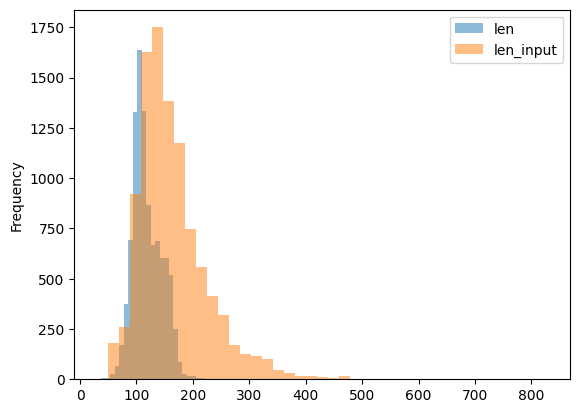

In [ ]:
df['len'] = [len('\n'.join(ast.literal_eval(x))) for x in df['stanzas']]
df['len_input'] = [len(x) for x in df['input']]
df['len'].plot.hist(bins=40, alpha=0.5)
df['len_input'].plot.hist(bins=40, alpha=0.5)
plt.legend()

Distribution of difference of lens of prose and poetry.

<Axes: ylabel='Frequency'>

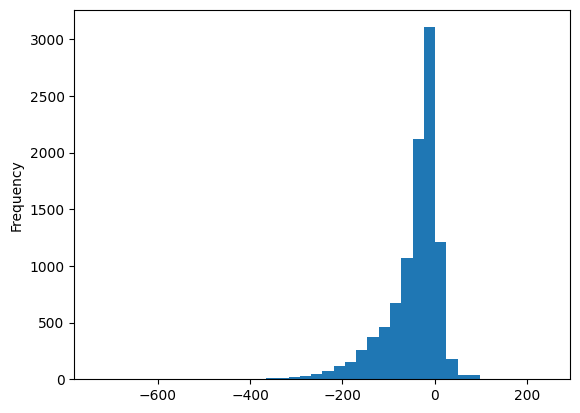

In [ ]:
(df['len'] -df['len_input']).plot.hist(bins=40)

Create file `temp_train.csv` with bad examples: they can have jaccard_similarity between prose and poetry more than 0.7; absolute difference between lens of prose and poetry more than 250; or one of lines of prose can remain unchanged.

In [ ]:
df_new = []
for i, row in df.iterrows():
    st = ast.literal_eval(row['stanzas'])
    if len(st) != 4:
        print(i, row['stanzas'])
    if (
        jaccard_similarity(row['input'], '\n'.join(st)) > 0.7 or
         abs(row['len'] -row['len_input']) > 250 or
        st[0].lower() in row['input'].lower() or
        st[1].lower() in row['input'].lower() or
        st[2].lower() in row['input'].lower() or
        st[3].lower() in row['input'].lower()):
        
        df_new.append(row)
df_new = pd.DataFrame(df_new)
df_new.to_csv('temp_train.csv')

This code uses Gemini-2.0-Flash for creating prose from stanzas from file `temp_train.csv`. Then it saves new prose in column `new_input` and resaves file `temp_train.csv`.

In [ ]:
def use_gemini_inv(text):
    while True:
        try:
            model = genai.GenerativeModel(
                        model_name="gemini-2.0-flash",
                        system_instruction=system_instruction_inv)
            response = model.generate_content(text)
            return response.text
        except:
            print('error')
            sleep(30)

In [ ]:
answers = generate_model_answers_inv(use_gemini_inv, from_id=0, file_path='temp_train.csv')
answers.to_csv('gemini.csv', index=False)

In [ ]:
df = pd.read_csv('temp_train.csv', index_col=0)
ans = pd.read_csv('gemini.csv')['0'].values
df['new_input'] = ans
df.to_csv('temp_train.csv')

Then the `input` column is rewritten by the `new_input` column if the new values have better jaccard_similarity or better difference of lens. 

In [ ]:
df_new = pd.read_csv('temp_train.csv', index_col=0)
df_new['new_input'] = df_new['new_input'].apply(clean_text)
for i, row in df_new.iterrows():
    st = ast.literal_eval(row['stanzas'])
    if (
        jaccard_similarity(row['input'], '\n'.join(st)) > jaccard_similarity(row['new_input'], '\n'.join(st)) or
         abs(row['len'] -row['len_input']) > abs(row['len'] - len(row['new_input']))):
        df_new.loc[i, 'input'] = row['new_input']

Resave `trainset.csv` with new input from `temp_train.csv`.

In [ ]:
df = pd.read_csv('trainset.csv', index_col=0)
df.loc[df_new.index, 'input'] = df_new['input']
df.to_csv('trainset.csv')